In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r "/content/drive/My Drive/deep_learning_projects/shakespeare_sonnets_generation/shakespeare_sonnets_dataset.txt" ./shakespeare_sonnets_dataset.txt
!ls

drive  sample_data  shakespeare_sonnets_dataset.txt


### Import Libraries

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
import random
import os

import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.2.0-rc4


### Load the text and covert to lowercase

In [0]:
filename = "shakespeare_sonnets_dataset.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

### Visualize Dataset

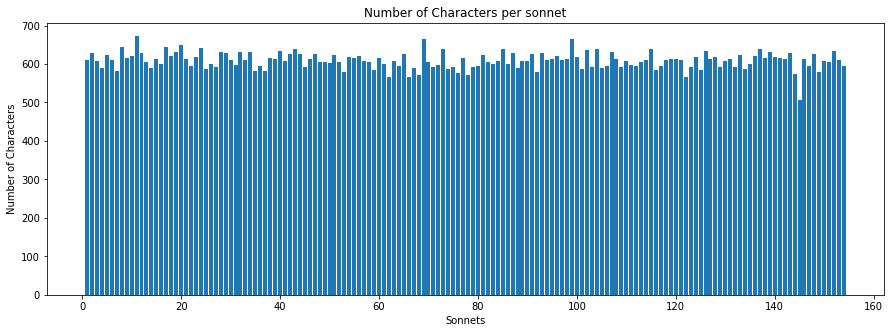

Maximum sonnet length: 673.00 characters
Minimum sonnet length: 506.00 characters
Average sonnet length: 608.94 characters


In [3]:
sonnets = raw_text.split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]

plt.figure(figsize=(15, 5))
plt.bar([i for i in range(1, len(sonnets)+1)], sonnet_lens)
plt.title('Number of Characters per sonnet')
plt.ylabel('Number of Characters')
plt.xlabel('Sonnets')
plt.show()


print('Maximum sonnet length: %.2f characters' % np.max(sonnet_lens))
print('Minimum sonnet length: %.2f characters' % np.min(sonnet_lens))
print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))

### Preprocessing of Data

In [0]:
# create mapping of unique characters to integers and integers to unique characters
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [5]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  94082
Total Vocab:  38


In [6]:
# cut the text in semi-redundant sequences of maxlen (40) characters

maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(raw_text) - maxlen, step):
    sentences.append(raw_text[i: i + maxlen])
    next_chars.append(raw_text[i + maxlen])
print('number of sequences:', len(sentences))

number of sequences: 31348


In [0]:
# Vectorization

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

### Defining the Model

Here we define a single hidden LSTM layer with 128 memory units. The output layer is a Dense layer using the softmax activation function to output a probability prediction for each of the 38 characters between 0 and 1.

In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               85504     
_________________________________________________________________
dense (Dense)                (None, 38)                4902      
Total params: 90,406
Trainable params: 90,406
Non-trainable params: 0
_________________________________________________________________


There is no test dataset. We are modeling the entire training dataset to learn the probability of each character in a sequence.

#### Defining Callback Class and helper functions for model.fit

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:

class myCallback(Callback):


  def on_epoch_end(self, epoch, logs={}):
      # Function invoked at end of each epoch. Prints generated text.
      print('')
      base_dir = 'generated_text'
      if not os.path.isdir(base_dir):
          os.mkdir(base_dir)
      
      epoch_dir = os.path.join(base_dir, 'epoch_' + str(epoch))
      if not os.path.isdir(epoch_dir):
          os.mkdir(epoch_dir)

      start_index = random.randint(0, len(raw_text) - maxlen - 1)
      for diversity in [0.2, 0.5, 1.0, 1.2]:
        
          diversity_file = 'epoch' + str(epoch) + '_diversity=' + str(diversity) + '.txt'
          file = open(os.path.join(epoch_dir, diversity_file), 'w')

          generated = ''
          sentence = raw_text[start_index: start_index + maxlen]
          generated += sentence
          
          file.write(generated)

          for i in range(600):
              x_pred = np.zeros((1, maxlen, len(chars)))
              for t, char in enumerate(sentence):
                  x_pred[0, t, char_to_int[char]] = 1.

              preds = model.predict(x_pred, verbose=0)[0]
              next_index = sample(preds, diversity)
              next_char = int_to_char[next_index]

              sentence = sentence[1:] + next_char

              file.write(next_char)
        
          print('diversity ' + str(diversity) + " done.")
          file.close()

#### Create Checkpoint and callback

In [11]:
# define the checkpoint
directory = 'model'
if not os.path.isdir(directory):
    os.mkdir(directory)
%cd model
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss')
callback = [checkpoint, myCallback()]


/content/model


### Train the model

In [12]:
history = model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=callback)

Epoch 1/60
245/245 [==============================] - ETA: 0s - loss: 2.3956
diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
245/245 [==============================] - 86s 349ms/step - loss: 2.3956
Epoch 2/60
245/245 [==============================] - ETA: 0s - loss: 1.9361
diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
245/245 [==============================] - 85s 349ms/step - loss: 1.9361
Epoch 3/60
245/245 [==============================] - ETA: 0s - loss: 1.7593
diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
245/245 [==============================] - 85s 346ms/step - loss: 1.7593
Epoch 4/60
245/245 [==============================] - ETA: 0s - loss: 1.6394
diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
245/245 [==============================] - 85s 347ms/step - loss: 1.6394
Epoch 5/60
245/245 [==============================] - ETA: 0s - loss: 1.5364
div

### Generate Sonnets

In [0]:
def generate_sonnet(temp):
    ''' Given a temperature, generate a new sonnet '''
    start_idx = np.random.randint(0, len(raw_text) - maxlen - 1)
    new_sonnet = raw_text[start_idx:start_idx + maxlen]
    print(new_sonnet)
    for i in range(600):
        # Vectorize generated text
        sampled = np.zeros((1, maxlen, len(chars)))
        for j, char in enumerate(new_sonnet):
            sampled[0, j, char_to_int[char]] = 1.

        # Predict next character
        preds = model.predict(sampled, verbose=0)[0]
        pred_idx = sample(preds, temperature=temp)
        next_char = chars[pred_idx]

        # Append predicted character to seed text
        new_sonnet += next_char
        new_sonnet = new_sonnet[1:]

        # Print to console
        print(next_char, end = '')


Below are some examples of generated sonnets with increasing randomness

In [14]:
generate_sonnet(0.2)

ould task you to recite
what merit lived
 thy bor, fairing of my proms,
ast i not sain the survered of thy wide once,
thou lov'st thou that which it they see's hate,
with true, is please that thou first rhade.
rice he write the stronger toon hus recont.
leaths but fall the foul as my love, to spricedranted;
the stronger the were of thy beauty be more.
the brow that thee thou in thy will's ben be.

nobe up not such a namby more be contents scurled stay,
which i seener do brong the were as your distil,
him in the strongen len of lessersel.
with all the world and spends of your will
by courth in the lives and health,
whilst one, that i 

In [15]:
generate_sonnet(0.4)

pt seat in one.

when in the chronicle o
f my pasters best but still deembld.
your lame, not kind winger thee of my heart,
making have a play the face to self;
the brow that every hand comming poitt,
too was flast with my love, fast to make.
but thou ass the strill'd hath he coursed,
and lot untast then i but undlanties bure,
and the survive thou liv's what thou tooself,
if though though thous, ant confought to self:
but dispit brieve thee thoughts thy though thought, nor not, doth traven:
bu what they gand the mour, nor dead same;
boing have i chilst in thy self-ends the deed.

but least in the lives where is best brame,
more fair w

In [16]:
generate_sonnet(0.6)

w;
now, while the world is bent my deeds
's beckecty,
and foul his but to times of werth in sick,
the ol, and to his rage shall age of my heart,
so yet mabes a to my state all my reasops prease,
and mether stay on your sweet well.
ster such a could aturel true, if let lesse,
and mad worms when thou see' wide woad be.

now lest with he courl as an in my love,
thy hand, so muth toow of youth wherelf reckert,
and houn whating in the strong one, the stay,
but and bast so chil then thy sweet verunt;
but of thy sweet feve thy grace to will my beauty,
and make me with me a  wonhers to this comp
incont hapy postence to thy parthen away.
lein

In [17]:
generate_sonnet(0.8)

lts graces that to thee resort.
as on th
e surk and thing of your light,
as thou undrange still deed, gone, now respill
aforthen tour from mement pride in this could not keetsss;
thy , s.bith but of beauty on your oft,
still loving thy of my jyuth and invence sicht;
and that this shadowh than thou forne, and ill
where impsed not time's love with love,
the stay on thine early dead sall which in thee,
while when beseen were i chould leave deat,
nou make the carless eyes doth truetme deatyvit,
and counteratiment difime thee to make.
but he chourly dead shame
as from thou time wars not keemswhen best.
but in the earer the face thou dost 

In [18]:
generate_sonnet(1.0)

dows green,
gilding pale streams with he
 glos'n detot the pitted;
the ow geeder trimmly i to the wered byours;
ast it to his charwing to thou may'nt are one on crook,
o! far thou some ones, and to heaven grace:
yee hands be mine eye hath every by thought,
to bear with helve prey belieded;
the ealoned fer confauther gones, some one,
that i say of my sake of men lovep,
ferewil sue sweld muring both forred from this .
ipill me not kind, my hearth unkents
that thus, my perpeaus in thy weret be w;.
truth in this,
and i great worse of your will were my are,
and out the stronglly gailen to me sound
when boso tich, but detied from thee to m

### Visualization the Model Loss

dict_keys(['loss'])


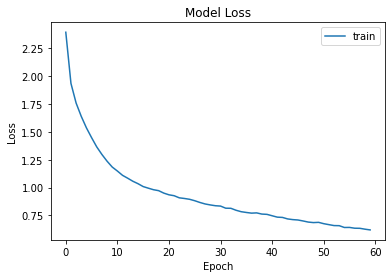

Model Loss = 0.6192405223846436


In [19]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

print("Model Loss =", history.history['loss'][-1])

### Save the Model

In [0]:
model.save('shakespeare_model.h5')

In [0]:
from tensorflow.keras.models import load_model

# Load model
model = load_model('shakespeare_model.h5')